**Class 1: MDPs and model-based policy search**

Notation: MDP = Markov Decision Process
1. [Everything you need to know](#everything)
2. [Modeling sequential decision problems with MDPs](#modeling)
    1. [My first Markov Decision Processes](#mdp)
    2. [Some Gym notions](#gym)
    3. [Policies](#policies)
    4. [Value Functions](#values)
    5. [Optimal policies](#optimal)
    6. [Evaluation equation](#eval)
    7. [Optimality equation](#optimality)
    8. [Summary](#summary)
3. [Optimizing policies - algorithms](#algos)
  1. [Value Iteration](#vi)
  2. [Policy Iteration](#pi)
  3. [Policy optimization with linear programming](#lp)
  4. [Asynchronous Dynamic Programming](#adp)
4. [Model-free Reinforcement Learning](#rl)
  1. [Taxonomy of Machine Learning](#taxonomy)
  2. [Introduction to model-free Reinforcement Learning](#introrl)

# <a id="everything"></a>Everything you need to know


Everything you should remember after this session.
<div class="alert-success">
<ul>
<li> A Markov Decision Process (MDP) is a 4-tuple $\langle S,A,p,r \rangle$. $S$ is the state space, $A$ is the action space, $p(s'|s,a)$ the transition model and $r(s,a)$ the reward model.
<li> A policy is a mapping $\pi:S\rightarrow A$ that specifies what to do in a given state.
<li> Value function of a policy: $V^\pi(s)=\mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s, \pi \right)$
<li> State-action value function of a policy $Q^\pi(s,a) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s, a_0=a, \pi \right)$
<li> Optimal policy $\pi^*$ dominates every other possible policy in every state: $\forall s, \ V^*(s) = V^{\pi^*}(s) \geq V^\pi(s)$
<li> Evaluation equation: $V^\pi \in \mathcal{F}\left(S,\mathbb{R}\right)$ is the only solution to $V\left(s\right) = (T^\pi V)(s) = r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V\left(s'\right)$<br>
Similarly, $Q^\pi \in \mathcal{F}\left(S\times A,\mathbb{R}\right)$ is the only solution to $Q\left(s,a\right) = (T^\pi Q)(s,a) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) Q\left(s', \pi\left(s'\right)\right)$
<li> Properties of $T^\pi$ 1) $V=T^\pi V$ is a linear system, 2) $T^\pi$ is a contraction mapping over $\mathcal{F}(S,\mathbb{R})$ or $\mathcal{F}(S\times A,\mathbb{R})$.
<li> Finding $V^\pi$ or $Q^\pi$: by matrix inversion or by repeatedly applying $T^\pi$ to any initial function.
<li> Optimality equation: $V^* \in \mathcal{F}\left(S,\mathbb{R}\right)$ is the only solution to $V(s) = (T^* V) (s) = \max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V(s') \right\}$<br>
Similarly, $Q^* \in \mathcal{F}\left(S\times A,\mathbb{R}\right)$ is the only solution to $Q(s,a) = (T^* Q) (s,a) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) \max\limits_{a'\in A} Q(s',a')$
<li> $T^*$ is a contraction mapping.
<li> Value Iteration: finding $V^*$ or $Q^*$ by repeatedly applying $T^*$ to any initial function.
<li> Policy Iteration: finding $V^*$ or $Q^*$ and $\pi^*$ by building the sequence $\pi_{n+1}(s) = \arg\max_{a\in A} Q^{\pi_n}(s,a)$ that converges to $\pi^*$. Repeatedly alternates an evaluation and an improvement phase.
<li> An OpenAI Gym environment has a standard API with 5 methods (step, reset, render, close, seed) and 3 attributes (action_space, observation_space, reward_range). Environment-specific features can be accessed via the "unwrapped" attribute.
</ul>
</div>

Of course, all this seems very obscure right now and the block above will only serve as a reminder when you re-open the notebook later. We will introduce every concept intuitively and progessively.

# <a id="modeling"></a>Modeling sequential decision problems with MDPs

## <a id="mdp"></a>My first Markov Decision Process

A few `import` first.

In [1]:
import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

We shall start with the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) game and work our way to more general concepts. It's also the occasion to familiarize with OpenAI Gym.

In [2]:
env = gym.make('FrozenLake-v0')
_=env.render()

[2017-12-14 10:16:55,236] Making new env: FrozenLake-v0



SFFF
FHFH
FFFH
HFFG


Let's take a look at this problem's description (using for example `help(fl.FrozenLakeEnv)`). We read:

`|  Winter is here. You and your friends were tossing around a frisbee at the park
|  when you made a wild throw that left the frisbee out in the middle of the lake.
|  The water is mostly frozen, but there are a few holes where the ice has melted.
|  If you step into one of those holes, you'll fall into the freezing water.
|  At this time, there's an international frisbee shortage, so it's absolutely imperative that
|  you navigate across the lake and retrieve the disc.
|  However, the ice is slippery, so you won't always move in the direction you intend.
|  The surface is described using a grid like the following
|  
|      SFFF
|      FHFH
|      FFFH
|      HFFG
|  
|  S : starting point, safe
|  F : frozen surface, safe
|  H : hole, fall to your doom
|  G : goal, where the frisbee is located
|  
|  The episode ends when you reach the goal or fall in a hole.
|  You receive a reward of 1 if you reach the goal, and zero otherwise.`

So it's a game of navigation.<br>
<br>
<div class="alert-warning">**Questions:**<br>What are the possible states of an agent in this game?<br> What are its possible actions?<br>How would you describe the result of action $a$ in state $s$?<br> How would you formalize mathematically the goal of an agent?</div>

<div class="alert-danger"><a href="#answers1" data-toggle="collapse">**Answers:**</a><br>
<div id="answers1" class="collapse">
States set: the 16 positions on the map.<br>
Actions set: the 4 actions $\{$N,S,E,W$\}$<br>
$s'$ resulting from $(s,a)$ follows a distribution $P(s'|s,a)$<br>
Since each time step yields a reward, reaching the goal $\Leftrightarrow$ $\max \sum r_t$
</div>
</div>

Let's develop a general theory for describing environments such as the FrozenLake game. Here is the main result we will develop on the white board or the presentation:<br>
<br>
<div class="alert-success">**Markov Decision Process (MDP)**<br>
A Markov Decision Process is given by:
<ul>
<li> A set of states $S$
<li> A set of actions $A$
<li> A (Markovian) transition model $p(s'|s,a)$
<li> A reward model $r(s,a)$ or $r(s,a,s')$
<li> A set of discrete decision epochs $T=\{0,1,\ldots,H\}$
</ul>
</div>

<a href="#moreMDP" data-toggle="collapse"> More?</a><br>
<div id="moreMDP" class="collapse">
1. Illustration of an MDP's components:
<img src="images/transitions.png">
2. And the resulting dynamics:
<img src="images/mdp2.png">
3. If $H\rightarrow\infty$ we have an infinite horizon planning problem.<br>
4. We shall see that the two formulations $r(s,a)$ and $r(s,a,s')$ are actually equivalent. We will admit that for now and will only use $r(s,a)$.
</div>
Since we will only work with infinite horizon problems, we shall identify the MDP with the 4-tuple $\langle S,A,p,r\rangle$.<br>
<br>
<div class="alert-warning">**Question**<br>
Now, can you identify the MDP underlying the FrozenLake game?
</div>
<br>
Let's confirm that:

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(16)


Using `print(help(gym.envs.toy_text.discrete))` one sees that all discrete state environments (such as FrozenLake) have the same inner attributes:

`|  - nS: number of states
|  - nA: number of actions
|  - P: transitions (*)
|  - isd: initial state distribution (**)
|  
|  (*) dictionary dict of dicts of lists, where
|    P[s][a] == [(probability, nextstate, reward, done), ...]
|  (**) list or array of length nS`

In [4]:
print(env.unwrapped.P[1][0])
print(env.unwrapped.P[1][0][0])

[(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True)]
(0.3333333333333333, 1, 0.0, False)


Just a few utility stuff from the FrozenLake environment (so that you don't spend time on useless things):

In [5]:
actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}
print(actions)

def to_s(row,col):
    return row*env.unwrapped.ncol+col

def to_row_col(s):
    col = s%env.unwrapped.ncol
    row = int((s-col)/env.unwrapped.ncol)
    return row,col

{0: '←', 1: '↓', 2: '→', 3: '↑'}


## <a id="gym"></a>Some Gym notions

Gym environments all are encapsulated so that they have the same API. This can be described by calling `help(gym.Env)` Namely, they all have 5 methods and 3 attributes.

Methods:
- `step` --- Runs one timestep of the environment's dynamics. When end of episode is reached, you are responsible for calling `reset()`  to reset this environment's state. Accepts an action and returns a tuple (observation, reward, done, info).
- `reset` --- Resets the state of the environment and returns an initial observation.
- `render` --- Renders the environment. The set of supported modes varies per environment. See `help(gym.Env.render)` for details and arguments.
- `close` --- Cleans everything up, shuts the light and closes the door.
- `seed` --- Sets the seed for this env's random number generator(s).

Attributes:
- `action_space` --- The Space(*) object corresponding to valid actions.
- `observation_space` --- The Space(*) object corresponding to valid observations.
- `reward_range` --- A tuple corresponding to the min and max possible rewards.

(*) `Space` is a class (`help(gym.Space)`) that defines a set, be it continuous or discrete, with some useful methods. It is used specifically as the type of the action and observation spaces.

Beyond those common API methods, some class-specific methods or attributes can be accessed by using the `unwrapped` attribute of each environment (if present) as in the example above.

General references on OpenAI Gym:
- [The short description paper](https://arxiv.org/pdf/1606.01540.pdf)
- [The github page](https://github.com/openai/gym/blob/master/gym/envs/toy_text/discrete.py) (the most useful resource!)
- [The general introduction to Gym](https://gym.openai.com/docs/)
- [The deprecated list of environments](https://gym.openai.com/envs/) (refer to the github page for the latest version).

## <a id="policies"></a>Policies

Now the question is: "formally, how does one write the behaviour of an agent in the game?". This behaviour provides the agent with an action given everything the agent has seen since the game started. Let's call such a behaviour a *policy* and define the broadest possible family of policies.

At time step $t$, action $a$ is picked with probability $\delta_t(a|h)$, where $h$ is the history of state and actions seen between the initial time step and $t$.

<div class="alert-success">**Policy $\pi$**<br>
A policy $\pi$ is a sequence of decision rules $\delta_t$: $\pi = \{\delta_t\}_{t\in T}$,<br>
with $\delta_t : \left\{\begin{array}{ccc}
S^{t+1}\times A^{t} & \rightarrow & \mathcal{P}'(A)\\h & \mapsto & \delta_t(a|h)
\end{array}\right.$
</div>
In other words:
$\delta_t(a|h)$ indicates<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the distribution over action $a$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; to undertake at time $t$, given<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the history of states/actions $h$.

This is a *history-dependent, non-stationary, stochastic* policy.

Ok, that's quite a complicated definition but we said we wanted to be generic so we will keep that for now.

## <a id="values"></a>Value functions

Now we want to find the best strategy for our game, ie. the best policy, so the question is "how can one say that one policy is better than another?". Consequently, we need to define criteria over policies.

The baseline idea is to say that the criterion should reflect what the agent gains by applying the policy. Two problems arise:
- this gain depends on the initial state
- two applications of the policy can result in two different trajectories since the agent's environment is stochastic (it's an MDP, remember)

Let us introduce three criteria as examples to give a general intuition of various possibilities. Bear in mind that many more (exotic) criteria are possible, they simply express what we consider an optimal behaviour. The three criteria below are actually functions, that map an **initial state** $s$ to the **expected** return the agent gets by applying the policy from $s$.

<table>
<tr>
    <td> Average reward </td>
    <td width="300px">$V(s) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty}  \frac{1}{H} \sum\limits_{t = 0}^H r_t \bigg| s_0 = s \right)$ </td>
    <td></td>
</tr>
<tr>
    <td> Total reward </td>
    <td>$V(s) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H r_t \bigg| s_0 = s \right)$ </td>
    <td></td>
</tr>
<tr>
    <td>Discounted reward </td>
    <td>$V(s) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s \right)$ </td>
    <td width="150px">with $0\leq \gamma<1$</td>
</tr>
</table>

- The average reward criterion characterizes the average reward per time step the agent gets. This can be useful in some control applications. However, in the case of FrozenLake, we don't want to average our rewards, we want to get our frisbee as soon as possible.
- The total reward criterion seems more adapted: it maximizes the cumulated rewards obtained during an episode. But it does not disciminate whether they were obtained at the beginning or late in the episode. Additionnaly, it suffers from a major flaw: for infinite horizon problems, even if the reward model is bounded, this sum might diverge. So we need a better formulation for the general case of infinite horizon problems.
- The discounted reward criterion suits our needs. The gamma factor ($0\leq \gamma<1$) guarantees that with bounded reward models $r$, the sum always converges. Also it has the properties we desire: a reward of 1 obtained at the first time step weights 1 in the final criterion, while a reward of 1 obtained after $t$ time steps only weights $\gamma^t$; it is *discounted* by $\gamma^t$ (hence the criterion's name).

From now on we shall concentrate on the discounted reward criterion. Given this criterion, we can introduce the notion of a value function.<br>
<br>
<div class="alert-success">**Value function $V^\pi$ of a policy $\pi$ under a $\gamma$-discounted criterion**<br>
$$V^\pi : \left\{\begin{array}{ccl}
S & \rightarrow & \mathbb{R}\\
s & \mapsto & V^\pi(s)=\mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s, \pi \right)\end{array}\right. $$
</div>
<br>
<div class="alert-warning">**Exercice**<br>
Use the FrozenLake environment we've introduced earlier to obtain a Monte-Carlo estimate of $V^\pi(s_0)$ over 100000 trials, with $s_0$ being the initial state and $\pi$ being a simple policy that always goes right. Take $\gamma = 0.9$.
</div>
Note that $\gamma^{200} \sim 10^{-9}$ so any reward obtained after 200 time steps will have a negligible contribution to $V^\pi(s_0)$, thus rolling an episode out for 200 time steps should be sufficient.

In [6]:
nb_episodes = 100000
horizon = 200
gamma = 0.9
Vepisode = np.zeros(nb_episodes)
for i in range(nb_episodes):
    env.reset()
    for t in range(horizon):
        next_state, r, done,_ = env.step(fl.RIGHT)
        Vepisode[i] += gamma**t * r
        if done:
            break
print("value estimate:", np.mean(Vepisode))
print("value variance:", np.std(Vepisode))

value estimate: 0.0129137021571
value variance: 0.0752319355514


## <a id="optimal"></a>Optimal policies

The fog clears up a bit: we can now compare policies given an initial state. We can now define what an optimal policy is.<br>
<br>
<div class="alert-success">**Optimal policy $\pi^*$**<br>
$\pi^*$ is said to be optimal iff $\pi^* \in \arg\max\limits_{\pi} V^\pi$.<br>
<br>
A policy is optimal if it **dominates** over any other policy in every state:
$$\pi^* \textrm{ is optimal}\Leftrightarrow \forall s\in S, \ \forall \pi, \ V^{\pi^*}(s) \geq V^\pi(s)$$
</div>

We now get to our first fundamental result. Fortunately for us...<br>
<br>
<div class="alert-success">**Optimal policy theorem**<br>
For $\left\{\begin{array}{l}
\gamma\textrm{-discounted criterion}\\
\textrm{infinite horizon}
\end{array}\right.$, 
there always exists at least one optimal stationary, deterministic, Markovian policy.
</div>

Let's explain a little:
- Markovian : $\left\{\begin{array}{l}
\forall \left(s_i,a_i\right)\in \left(S\times A\right)^{t-1}\\
\forall \left(s'_i,a'_i\right)\in \left(S\times A\right)^{t-1}
\end{array}\right., \delta_t\left(a|s_0, a_0, \ldots, s_t\right) = \delta_t\left(a|s'_0, a'_0, \ldots, s_t\right)$.\\
One writes $\delta_t(a|s)$.
- Stationary : $\forall (t,t')\in \mathbb{N}^2, \delta_t = \delta_t'$.\\
One writes $\pi = \delta_0$.
- Deterministic : $\delta_t(a|h) = \left\{\begin{array}{l}
1\textrm{ for a single }a\\
0\textrm{ otherwise}
\end{array}\right.$.

So in simpler words, we know that among all possible optimal policies, at least one is a function $\pi:S\rightarrow A$.

That helps a lot: we don't have to search for optimal policies in that complex family of history-dependent, stochastic, non-stationary policies, can simply search for a function $\pi(s)=a$ that maps states to actions.

<a href="#optPol" data-toggle="collapse"> Curious to know why?</a><br>
<div id="optPol" class="collapse">
The proof (very simple but a little long) is in chapter 6 of **Markov Decision Processes** (book by Martin L. Puterman).<br>
To give you the general flavour:
<ul>
<li> The infinite horizon leads to the existence of an optimal **stationary** policy: if the horizon is infinitely far, the optimal decision rule $n$ steps before the end if the same as the one $n+1$ steps before the end (watch out, this intuition can be very false)
<li> The **Markovian** property of $p(s'|s,a)$ allows to get optimal Markovian policies.
<li> The **deterministic** part is somehow more tricky but just note that this result only holds for single-player MDPs. For a two-agents competitive game for example (like poker for instance), there is no deterministic optimal policy.
</ul>
</div>




## <a id="eval"></a>Evaluation equation

Let's play a little bit (mathematically) with our new toys.<br>
<br>
<div class="alert-warning">**Question**
What's the value of "$a$ then $\pi$ from $s$"?
</div>

Note: the answer uses the discounted criterion's definition and the value function of $\pi$.<br>
<br>
<div class="alert-danger"><a href="#answers2" data-toggle="collapse">**Answer:**</a><br>
<div id="answers2" class="collapse">
\begin{align*}
Q^\pi(s,a) & = \mathbb{E}\left( \sum\limits_{t=0}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right)\\
 & = r\left(s,a\right) + \mathbb{E}\left( \sum\limits_{t=1}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right)\\
 & = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) \mathbb{E}\left( \sum\limits_{t=1}^\infty \gamma^{t-1} r\left(s_t, a_t\right) \bigg| s_1 = s', \pi \right)\\
 & = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) V^\pi\left(s'\right)
\end{align*}
</div>
</div>

Note that we have introduced the very important state-action value function $Q^\pi$.
<div class="alert-success">**State-action value function**<br>
$$Q^\pi(s,a) = \mathbb{E}\left( \sum\limits_{t=0}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right)$$
</div>

That's interesting: given a policy $\pi$, the best one-step lookahead action can be selected by maximizing $Q^\pi$.
- To improve on a policy $\pi$, it is more useful to know $Q^\pi$ than $V^\pi$ and pick the *greedy* action.
- Also $V^\pi(s) = Q^\pi(s,\pi(s))$. Let's replace that above and we get an important equation to characterize $V^\pi$.

<div class="alert-success">**Evaluation equation**<br>
$V^\pi$ is a solution to the linear system:
\begin{gather*}
V^\pi\left(s\right) = r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V^\pi\left(s'\right)\\
V^\pi = r^\pi + \gamma P^\pi V^\pi = T^\pi V^\pi
\end{gather*}
Similarly:
\begin{gather*}
Q^\pi\left(s,a\right) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) Q^\pi\left(s', \pi\left(s'\right)\right)\\
Q^\pi = r + \gamma P Q^\pi = T^\pi Q^\pi
\end{gather*}
</div>

<a href="#morePpi" data-toggle="collapse"> What are $P^\pi$, $r^\pi$ and $T^\pi$ here?</a><br>
<div id="morePpi" class="collapse">
When the state space is discrete, $V^\pi$ is vector of size $|S|$, $P^\pi$ is a matrix containing the values $P^\pi_{ij} = p\left(s_j|s_i,\pi(s_i)\right)$ and, similarly, $r^\pi$ is a vector containing the values $r^\pi_i = r(s_i,\pi(s_i))$. In better words, $P^\pi$ is the *transition kernel* of the Markov chain describing the state dynamics under policy $\pi$ and $r^\pi$ is the associated reward model.<br>
<br>
This generalizes straightforwardly to the continuous action case: $V^\pi$ is a function in the $\mathcal{F}(S,\mathbb{R})$ function space (the generalization of the vector in the previous sentence), $r^\pi$ becomes the function $s\mapsto r(s,\pi(s))$ and  $P^\pi$ becomes the operator over $\mathcal{F}(S,\mathbb{R})$ that maps function $V$ to $s\mapsto \int\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V\left(s'\right)ds'$.<br>
<br>
In the same fashion, one can define the $T^\pi$ operator. In the discrete state space case, $T^\pi$ is the linear operator in $\mathbb{R}^{|S|}$ that maps $V^\pi$ to $r^\pi + \gamma P^\pi V^\pi$.<br>
<br>
In the continuous state space case, $T^\pi$ is the linear operator in $\mathcal{F}(S,\mathbb{R})$ that maps $V^\pi$ to the function $s\mapsto r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V^\pi\left(s'\right)$.
</div>

<a href="#moreEval" data-toggle="collapse"> A remark</a><br>
<div id="moreEval" class="collapse">
For stochastic policies:
$\forall s\in S, \quad V^\pi(s) = \sum\limits_{a\in A} \pi(a|s) \left(r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a)V^\pi(s') \right)$
</div>

We've gone far from our original FrozenLake problem. Let's make all this very concrete:
- A policy $\pi$ is an agent's behaviour
- In every state $s$, one can expect to gain $V^\pi(s)$ in the long run by applying $\pi$
- The function $V^\pi$ actually obeys the linear system of equations above that simply link the value of a state with the values of its successors in an episode.

We can stop for a minute on the $T^\pi$ evaluation operator (that maps a function $S\rightarrow\mathbb{R}$ to a function $S\rightarrow\mathbb{R}$) and the search for $V^\pi$.<br>
<br>

<div class="alert-success">**Properties of $T^\pi$**<br>
<ol>
<li> $T^\pi$ is linear.<br>
$\Rightarrow$ Solving $V^\pi = T^\pi V^\pi$ and $Q^\pi = T^\pi Q^\pi$ by matrix inversion?<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With $\gamma<1$, $V^\pi = \left(I-\gamma P^\pi\right)^{-1}r^\pi$ and $Q^\pi = \left(I-\gamma P\right)^{-1}r^\pi$
<li> With $\gamma<1$, $T^\pi$ is a $\| \cdot \|_\infty$-contraction mapping over the $\mathcal{F}(S,\mathbb{R})$ (resp. $\mathcal{F}(S\times A,\mathbb{R})$) Banach space.<br>
$\Rightarrow$ With $\gamma<1$, $V^\pi$ (resp. $Q^\pi$) is the unique solution to the (linear) fixed point equation:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V=T^\pi V$ (resp. $Q=T^\pi Q$).
</ol>
</div>
<br>
<div class="alert-warning">**Exercice**<br>
Use the first property above to compute $V^\pi$ for the policy that always moves right. To do this, you'll need to compute $r^\pi$ and $P^\pi$. Again, $\gamma = 0.9$.
Check if your result for $V^\pi(s_0)$ is consistent with the Monte Carlo estimate.
</div>

In [7]:
gamma = 0.9
r_pi0 = np.zeros((env.observation_space.n))
P_pi0 = np.zeros((env.observation_space.n, env.observation_space.n))
for s in range(env.observation_space.n):
    outcomes = env.unwrapped.P[s][fl.RIGHT]
    for o in outcomes:
        p  = o[0]
        s2 = o[1]
        r  = o[2]
        P_pi0[s][s2] += p
        r_pi0[s] += p*r
I = np.eye(env.observation_space.n)
V_pi0 = np.dot(np.linalg.inv(I - gamma*P_pi0), r_pi0)
print(V_pi0)

[  1.308e-02   1.176e-02   2.744e-02   2.034e-16   1.875e-02   1.234e-16
   6.402e-02   2.712e-16   4.944e-02   1.460e-01   1.860e-01   0.000e+00
   0.000e+00   3.008e-01   5.559e-01   0.000e+00]


We could generalize that to a function that takes a policy as input. We'll suppose in this case that the policy is an array of actions.

In [8]:
def policy_eval_lin(pi):
    # build r and P
    r_pi = np.zeros((env.observation_space.n))
    P_pi = np.zeros((env.observation_space.n, env.observation_space.n))
    for x in range(env.observation_space.n):
        outcomes = env.unwrapped.P[x][pi[x]]
        for o in outcomes:
            p = o[0]
            y = o[1]
            r = o[2]
            P_pi[x,y] += p
            r_pi[x] += r*p
    # Compute V
    I = np.eye(env.observation_space.n)
    return np.dot(np.linalg.inv(I - gamma*P_pi), r_pi)

In [9]:
pi0 = fl.RIGHT*np.ones((env.observation_space.n))

V_pi0 = policy_eval_lin(pi0)
print(V_pi0)

[  1.308e-02   1.176e-02   2.744e-02   2.034e-16   1.875e-02   1.234e-16
   6.402e-02   2.712e-16   4.944e-02   1.460e-01   1.860e-01   0.000e+00
   0.000e+00   3.008e-01   5.559e-01   0.000e+00]


<div class="alert-warning">**Exercice**<br>
Use the second property above to compute $V^\pi$ for the policy that always moves right. To do this, you'll need to remember that since $T^\pi$ is a contraction mapping, the sequence $V_{n+1}=T^\pi V_n$ converges to $T^\pi$'s fixed point (which happens to be $V^\pi$ according to the property). Again, $\gamma = 0.9$. For a start, apply $T^\pi$ for a fixed number of steps `max_iter`.
Check if your result is consistent with the previous estimate.
</div>

In [10]:
def policy_eval_iter(pi, max_iter):
    V = np.zeros((env.observation_space.n))
    W = np.zeros((env.observation_space.n))
    for i in range(max_iter):
        for x in range(env.observation_space.n):
            W[x]=0
            outcomes = env.unwrapped.P[x][pi[x]]
            # W[x] = sum_y P[y] (r_y + gamma V[y])
            for o in outcomes:
                p = o[0]
                y = o[1]
                r = o[2]
                W[x] += p * (r+gamma*V[y])
        V[:] = W
    return V

V_pi0 = policy_eval_iter(pi0,10000)
print(V_pi0)

[ 0.013  0.012  0.027  0.     0.019  0.     0.064  0.     0.049  0.146
  0.186  0.     0.     0.301  0.556  0.   ]


We could make a matrix-operations version of the code above.

In [11]:
def policy_eval_iter_mat(pi, max_iter):
    # build r and P
    r_pi = np.zeros((env.observation_space.n))
    P_pi = np.zeros((env.observation_space.n, env.observation_space.n))
    for x in range(env.observation_space.n):
        outcomes = env.unwrapped.P[x][pi[x]]
        for o in outcomes:
            p = o[0]
            y = o[1]
            r = o[2]
            P_pi[x,y] += p
            r_pi[x] += r*p
    # Compute V
    V = np.zeros((env.observation_space.n))
    for i in range(max_iter):
        V = r_pi + gamma * np.dot(P_pi, V)
    return V

V_pi0 = policy_eval_iter_mat(pi0,10000)
print(V_pi0)

[ 0.013  0.012  0.027  0.     0.019  0.     0.064  0.     0.049  0.146
  0.186  0.     0.     0.301  0.556  0.   ]


Between two iterations in the algorithm above, the distance between $V_{n+1}$ and $V_n$ decreases as $\|V_{n+1}-V_n\| = \|r^\pi + \gamma P^\pi V_n - V_n\|$. Since $T^\pi$ is a contraction mapping, we have $\|V_{n+1}-V_n\| \leq \|V_{n}-V_{n-1}\|$. Let's call this distance at time step $n$ the **residual**. Then the successive residuals monotonically tend to zero.<br>
<br>
<div class="alert-warning">**Exercice:**<br>
Now, can you use the property on the residuals to replace `max_iter` by a precision parameter `epsilon` that specifies the maximum error on $V^\pi$? Advice: still keep `max_iter` to stop the computation in case you specify an `epsilon` that is too small. Return both $V^\pi$ and the sequence of residuals. Plot the sequence of residuals and display the number of iterations necessary to reach the chose precision `epsilon`.
</div>

[ 0.013  0.012  0.027  0.     0.019  0.     0.064  0.     0.049  0.146
  0.186  0.     0.     0.301  0.556  0.   ]
number of iterations: 17
last residual 7.98861048318e-05


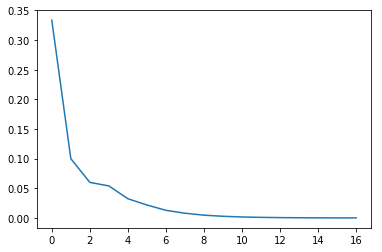

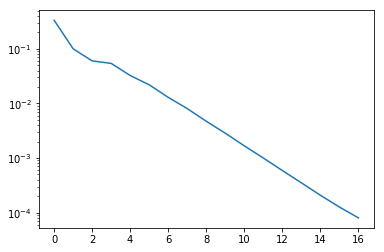

In [12]:
def policy_eval_iter_mat2(pi, epsilon, max_iter):
    # build r and P
    r_pi = np.zeros((env.observation_space.n))
    P_pi = np.zeros((env.observation_space.n, env.observation_space.n))
    for x in range(env.observation_space.n):
        outcomes = env.unwrapped.P[x][pi[x]]
        for o in outcomes:
            p = o[0]
            y = o[1]
            r = o[2]
            P_pi[x,y] += p
            r_pi[x] += r*p
    # Compute V
    V = np.zeros((env.observation_space.n))
    W = np.zeros((env.observation_space.n))
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        W = r_pi + gamma * np.dot(P_pi, V)
        residuals[i] = np.max(np.abs(W-V))
        V[:] = W
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return V, residuals

V_pi0, residuals = policy_eval_iter_mat2(pi0,1e-4,10000)
print(V_pi0)
plt.plot(residuals)
plt.figure()
plt.semilogy(residuals)
print("number of iterations:", residuals.size)
print("last residual", residuals[-1])

## <a id="optimality"></a>Optimality equation

Ok, so given a policy, we have a way (two actually) to compute its value function. Now we would like to find the optimal policy and we'd rather not enumerate all possible policies.

Let's introduce some notations and start with two trivial remarks. We write:
$$V^{\pi^*} = V^*, \quad Q^{\pi^*} = Q^*$$

Then we can note that:
1. $Q^*\left(s,a\right) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S}p\left(s'|s,a\right) V^*\left(s'\right)$
2. If $\pi^*$ is an optimal policy, then $V^*\left(s\right) = Q^*\left(s,\pi^*\left(s\right)\right)$

From the first remark, we note that the maximum expected return one can get from a trajectory initiated in $s$ starts with the action $a$ that maximizes $Q^*(s,a)$. So:
<div class="alert-success">**Optimal greedy policy**<br>
Any policy $\pi$ defined by $\pi(s) \in \arg\max\limits_{a\in A} Q^*(s,a)$ is an optimal policy.
</div>

Consequently, finding $\pi^*$ is equivalent to finding $Q^*$.

Here comes the key theorem of this class:
<div class="alert-success">**Bellman optimality equation**<br>
The optimal value function obeys:
$$V^*(s) = \max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V^*(s') \right\}=(T^* V^*) (s)$$
or in terms of $Q$-functions:
$$Q^*(s,a) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) \max\limits_{a'\in A} Q^*(s',a')=(T^* Q^*) (s,a)$$
</div>

Why does that unfold intuitively from the previous remarks? Simply because of the Dynamic Programming principle: any subpath of an optimal path is itself optimal. That might still sound obscure. So let's say that if you start a trajectory in $s$ and if you know you will get the maximum value from any state $s'$ you reach, then the maximum value you can get from $s$ is precisely $\max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V^*(s') \right\}$. The actual proof is quite trickier but the key ideas are here.<br>
<br>
As for the policy evaluation operator $T^\pi$, we define the **Bellman optimality operator** $T^*$ as above.<br>
<br>
<div class="alert-success">**Properties of $T^*$**<br>
<ol>
<li> $T^\pi$ is non-linear.<br>
<li> With $\gamma<1$, $T^*$ is a $\| \cdot \|_\infty$-contraction mapping over the $\mathcal{F}(S,\mathbb{R})$ (resp. $\mathcal{F}(S\times A,\mathbb{R})$) Banach space.<br>
$\Rightarrow$ With $\gamma<1$, $V^*$ (resp. $Q^*$) is the unique solution to the fixed point equation:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V=T^* V$ (resp. $Q=T^* Q$).
</ol>
</div>
<br>
<div class="alert-warning">**Exercice**<br>
Use the property above to compute $V^*$. To do this, you'll need to remember that since $T^*$ is a contraction mapping, the sequence $V_{n+1}=T^* V_n$ converges to $T^*$'s fixed point (which happens to be $V^*$ according to the property). Again, $\gamma = 0.9$.
</div>

[ 0.068  0.061  0.074  0.055  0.091  0.     0.112  0.     0.145  0.247
  0.299  0.     0.     0.38   0.639  0.   ]
number of iterations: 44
last residual 9.27242271501e-05


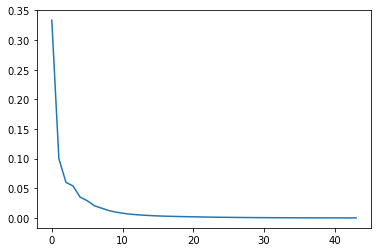

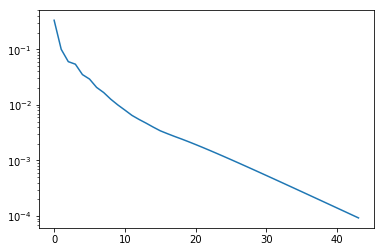

In [13]:
def vf_optim(V, epsilon, max_iter):
    W = np.copy(V)
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for s in range(env.observation_space.n):
            Q = np.zeros((env.action_space.n))
            for a in range(env.action_space.n):
                outcomes = env.unwrapped.P[s][a]
                for o in outcomes:
                    p  = o[0]
                    s2 = o[1]
                    r  = o[2]
                    Q[a] += p*(r+gamma*V[s2])
            W[s] = np.max(Q)
            #print(W[s])
        residuals[i] = np.max(np.abs(W-V))
        #print("abs", np.abs(W-V))
        np.copyto(V,W)
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return V, residuals

Vinit = np.zeros((env.observation_space.n))
Vstar, residuals = vf_optim(Vinit, 1e-4, 10000)
print(Vstar)
plt.plot(residuals)
plt.figure()
plt.semilogy(residuals)
print("number of iterations:", residuals.size)
print("last residual", residuals[-1])

## <a id="summary"></a>Summary

Let's wrap this whole section up. Our goal was to formally define the search for the best strategy for our game of FrozenLake. This has led us to formalizing the general **discrete-time stochastic optimal control problem**:
- Environment (discrete time, non-deterministic, non-linear) $\leftrightarrow$ MDP.
- Behaviour $\leftrightarrow$ control policy $\pi : s\mapsto a$.
- Policy evaluation criterion $\leftrightarrow$ $\gamma$-discounted criterion.
- Goal $\leftrightarrow$ Maximize value function $V^\pi(s)$, $Q^\pi(s,a)$.
- Evaluation eq. $\leftrightarrow$ $V^\pi = T^\pi V^\pi$, $Q^\pi = T^\pi Q^\pi$.
- Bellman optimality eq. $\leftrightarrow$ $V^* = T^* V^*$, $Q^* = T^* Q^*$.

# <a id="algos"></a>Optimizing policies - algorithms

From the analysis of the previous section, we introduce several algorithms to find $\pi^*$.

## <a id="vi"></a>Value Iteration

Value iteration is actually the algorithm we defined in function `vf_optim` above. It directly exploits the contraction mapping property of $T^*$ and iterates over value functions in order to converge to $V^*$. Once, $V^*$ is found, finding the optimal policy is a matter of writing $Q^*$ and defining a policy that is $Q^*$-greedy.<br>
<br>
<div class="alert-warning">**Exercice:**<br>
Compute and display an optimal policy for the FrozenLake game, using Value Iteration.
</div>

In [14]:
def value_iteration(V,epsilon,max_iter):
    return vf_optim(V,epsilon,max_iter)

def Q_from_V(V):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[s][a]
            for o in outcomes:
                p  = o[0]
                s2 = o[1]
                r  = o[2]
                Q[s,a] += p*(r+gamma*V[s2])
    return Q

def greedyQpolicy(Q):
    pi = np.zeros((env.observation_space.n),dtype=np.int)
    for s in range(env.observation_space.n):
        pi[s] = np.argmax(Q[s,:])
    return pi

def print_policy(pi):
    for row in range(env.unwrapped.nrow):
        for col in range(env.unwrapped.ncol):
            print(actions[pi[to_s(row,col)]], end='')
        print()
    return

Vinit = np.zeros((env.observation_space.n))
Vstar,residuals = value_iteration(Vinit,1e-4,1000)
Qstar = Q_from_V(Vstar)
print(actions)
print(Qstar)
pi_star = greedyQpolicy(Qstar)
print_policy(pi_star)
_=env.render()

{0: '←', 1: '↓', 2: '→', 3: '↑'}
[[ 0.068  0.066  0.066  0.059]
 [ 0.039  0.043  0.04   0.061]
 [ 0.074  0.068  0.072  0.057]
 [ 0.039  0.039  0.033  0.055]
 [ 0.091  0.071  0.064  0.048]
 [ 0.     0.     0.     0.   ]
 [ 0.112  0.09   0.112  0.022]
 [ 0.     0.     0.     0.   ]
 [ 0.071  0.118  0.102  0.145]
 [ 0.157  0.247  0.204  0.133]
 [ 0.299  0.266  0.225  0.108]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.188  0.306  0.38   0.266]
 [ 0.395  0.639  0.615  0.537]
 [ 0.     0.     0.     0.   ]]
←↑←↑
←←←←
↑↓←←
←→↓←
  (Right)
SFFF
FHFH
FFFH
HFFG


Those familiar with the principles of Dynamic Programming will note that Value Iteration is a Dynamic Programming algorithm that operates in value function space, monotonically hopping from value function to value function.

## <a id="pi"></a>Policy Iteration

The Policy Iteration algorithm stems from the following remark. Suppose we have a policy $\pi$ and know its value function $V^\pi$ and state-action value function $Q^\pi$. Then, the non-stationary policy $\pi'$ that acts greedily with respect to $Q^\pi$ for the first time step and then follows $\pi$ has a value function $V^{\pi'}$ that is greater or equal to $V^\pi$ (equal if $\pi$ is optimal, strictly greater otherwise). Actually, the contraction property of $T^*$ insures that the stationary policy $\pi''$ that is greedy with respect to $Q^\pi$ is at least as good as $\pi$, that is $V^{\pi'}\geq V^\pi$. Consequently, the sequence of policies defined by $\pi_{n+1}(s) = \arg\max_{a\in A} Q^{\pi_n}(s,a)$ has a monotonically improving corresponding sequence of value functions $V^{\pi_n}$ and converges to $\pi^*$.<br>
<br>
Let's make this more simple with a drawing. Policy iteration alternates two phases:
1. Evaluate $\pi_n$ $\rightarrow Q^{\pi_n}$
2. Compute $\pi_{n+1}$ as the $Q^{\pi_n}$-greedy policy

<img src="images/policyiteration.png">

<div class="alert-warning">**Exercice:**<br>
Compute and display an optimal policy for the FrozenLake game, using Policy Iteration.
</div>

In [17]:
def policy_iteration(pi0,max_iter):
    policies = np.zeros((max_iter, env.observation_space.n))
    policies[0,:] = np.copy(pi0)
    for i in range(max_iter-1):
        Vpi = policy_eval_iter_mat(policies[i],500)
        Qpi = Q_from_V(Vpi)
        policies[i+1,:] = greedyQpolicy(Qpi)
        if np.array_equal(policies[i,:],policies[i+1,:]):
            policies = policies[:i,:]
            break
    return policies

pi0 = fl.RIGHT*np.ones((env.observation_space.n))
print_policy(pi0)
policies = policy_iteration(pi0,10)
print("number of iterations:", policies.shape[0])
print_policy(policies[-1,:])
env.render()

→→→→
→→→→
→→→→
→→→→
number of iterations: 2
←↑←←
←←←←
↑↓←←
←→↓←
  (Right)
SFFF
FHFH
FFFH
HFFG


**Warning:** the stopping criterion $\pi_{n+1} = \pi_n$ is good in most cases. However, it is not robust to multiple optimal policies! In this case, Policy Iteration might alternate between two (or more) equivalent optimal policies. This happens also when the computation of $Q^{\pi_n}$ carries small errors. Even if its a bit more costly computationally, it might be safer to compare $V^{\pi_{n+1}}$ and $V^{\pi_n}$ and allow a precision error of $\epsilon$. To observe this phenomenon, just replace the `policy_eval_iter_mat` call by a call to `policy_eval_lin` (which carries the errors of matrix inversion): the algorithm does not terminate anymore and alternates between equivalent optimal policies.

In [16]:
def policy_iteration(pi0,max_iter):
    policies = np.zeros((max_iter, env.observation_space.n))
    policies[0,:] = np.copy(pi0)
    for i in range(max_iter-1):
        Vpi = policy_eval_lin(policies[i])
        Qpi = Q_from_V(Vpi)
        policies[i+1,:] = greedyQpolicy(Qpi)
        if np.array_equal(policies[i,:],policies[i+1,:]):
            policies = policies[:i,:]
            break
    return policies

pi0 = fl.RIGHT*np.ones((env.observation_space.n))
print_policy(pi0)
policies = policy_iteration(pi0,10)
print("number of iterations:", policies.shape[0])
print(policies[-2,:])
print(policies[-1,:])

→→→→
→→→→
→→→→
→→→→
number of iterations: 10
[ 0.  3.  0.  3.  0.  0.  0.  0.  3.  1.  0.  0.  0.  2.  1.  0.]
[ 0.  3.  0.  3.  0.  0.  2.  0.  3.  1.  0.  0.  0.  2.  1.  0.]


As for Value Iteration, those familiar with Dynamic Programming will remark that Policy Iteration is a Dynamic Programming algorithm in policy space, monotonically hopping from policy to policy.

## <a id="lp"></a>Linear Programming

If this is the first time you read this notebook, this part can be skipped. [Link to next part](#adp)

An alternative way of finding $V^*$ is by casting the optimality equation as a linear optimization problem. This formulation is mainly given for your curiosity and we will not study it any further.<br>
<br>
Recall the optimality equation:
$$\forall s\in S, V(s)=\max\limits_{a\in A} \left\{r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V(s')\right\}$$
The key remark to transform this into a linear program is to rephrase it as "$V^*$ is the smallest value that dominates over all policy values". This can be written as:
$$\left\{ \begin{array}{c}
\min \sum\limits_{s\in S} V(s)\\
s.t. \ \forall \pi, \ V \geq T^\pi V
\end{array} \right.$$
"For all $\pi$" means for all possible association $s\leftrightarrow a$, so this can be expanded as:
$$\left\{ \begin{array}{c}
\min \sum\limits_{s\in S} V(s)\\
s.t. \ \forall (s,a)\in S\times A, \quad V(s) - \gamma \sum\limits_{s'\in S} p(s'|s,a)V(s') \geq r(s,a)
\end{array}\right.$$
Which, finally, is a linear program with $|S|$ variables and $|S||A|$ constraints.

## <a id="adp"></a>Asynchronous Dynamic Programming

If this is the first time you read this notebook, this part can be skipped. [Link to next part](#rl)

We have seen that Value Iteration and Policy Iteration are Dynamic Programming algorithms. They follow a path, respectively in value function and in policy space that leads to $V^*$ and $\pi^*$. But we can remark that they both perform *state-wise* operations such as:

- $V(s) \leftarrow \max_{a} r(s,a) + \gamma \sum_{s'} p(s'|s,a) V(s')$ for value iteration
- $\pi(s) \leftarrow \arg\max_a Q^{\pi}(s,a)$ for policy iteration
- $V(s) \leftarrow r(s,\pi(s)) + \gamma \sum_{s'} p(s'|s,\pi(s)) V(s')$ for policy evaluation

These state-wise operations are called Bellman backups. Let's rename them, respectively:
- `BBVopt(V,s): return` $\max_{a} r(s,a) + \gamma \sum_{s'} p(s'|s,a) V(s')$
- `BBpiopt(V,s): return` $\arg\max_a r(s,a) + \gamma \sum_{s'} p(s'|s,a) V(s)$
- `BBVval(V,s): return` $r(s,\pi(s)) + \gamma \sum_{s'} p(s'|s,\pi(s)) V(s')$

Then we can rewrite value iteration as:<br>
`
V(s) = Vinit(s) for all s
while error>epsilon
  for s in S
    W(s) = BBVopt(V,s)
  error = norm(W-V)
  V = W
`

And policy iteration as:<br>
`
while(true)
  V(s) = 0 for all s
  for k=1 to K
    for s in S
      V(s) = BBVval(V,s)
  for s in S
    pi2 BBpiopt(V,s)
  if(pi == pi2)
    stop
  else
    pi = pi2
`

### <a id="avi"></a>Asynchronous Value Iteration

Let's take the pseudo-code of value iteration. Why don't we perform directly `V(s) = BBVopt(V,s)`, instead of relying on the intermediate `W` function? Doing so is actually called **Gauss-Seidl Value Iteration** and it opens the door to a much wider class of algorithms called Asynchronous Value Iteration.<br>
<br>
It is crucial to note that in Gauss-Seidl Value Iteration, the order in which the states are considered for backups greatly affects of rewards are propagated through the state space and how the sequence of value functions converges to $V^*$. But still, in Gauss-Seidl Value Iteration, states are updated once per sweep over the state space.

Why wouldn't we update the value of some states more often than others? Would the overall value function still converge to $V^*$? A very powerful theorem actually states that:
<div class="alert-success">As long as every state is visited infinitely often by the `V(s)` $\leftarrow$ `BBVopt(V,s)` operation as time tends to $+\infty$, the value function $V$ converges to $V^*$
</div>

Consequently, we could pick states totally randomly in order to perform Bellman backups on $V$ and $V$ would still converge to $V^*$. Although picking states randomly for that purpose seems like a bad idea, identifying a good ordering for the backups can lead to drastic improvements in convergence speed. This is the key idea of **Asynchronous Value Iteration** and has justified (among other things) the popular **Prioritized Sweeping** and **Real-Time Dynamic Programming** algorithms.

### <a id="api"></a>Asynchronous Policy Iteration

Let's now take the pseudo-code of policy iteration. The evaluation step and the improvement step are clearly separated. But one can note that if we require the evaluation step to have infinite precision, `K` needs to tend to $\infty$. So, realistic implementations of Policy Iteration, as the one we crafted earlier, tolerate some error on $V^\pi$. But could we take an arbitrary value for `K`? Would this still converge? The answer is yes and this algorithm is known as **Modified Policy Iteration**.

But then, can we push it a little further and say that `K=1`? Then in this case, Modified Policy Iteration becomes... Value Iteration (check it by yourself)!

As in the value iteration case, can we update the value or policy of a given state in any ordering? The answer is yes again and the theorem states that:
<div class="alert-success"> As long as every state is visited infinitely often by the `V(s)` $\leftarrow$ `BBVval(V,s)`  and the $\pi(s) \leftarrow$ `BBpiopt(V,s)` operations as time tends to $+\infty$, the value function $V$ and the policy $\pi$ converge respectively to $V^*$ and $\pi^*$
</div>

That is the most general framework one can give for **Asynchronous Dynamic Programming** in MDP resolution. It is often called **Asynchronous Policy Iteration**.<br>
<br>
<div class="alert-warning">**Exercice:**<br>
Instead of reasoning on state value functions $V$, we can work directly with state-action value functions $Q$ and policies $\pi$. Suppose we maintain a memory of a function $Q$ and a policy $\pi$, then we can define two Bellman backups:
<ul>
<li> `BBQ(s,a):` $Q(s,a) \leftarrow r(s,a) + \gamma \sum_{s'} p(s'|s,a) Q(s',\pi(s'))$
<li> `BBpi(s):` $\pi(s) \leftarrow \arg\max_a Q(s,a)$
</ul>
We can note the similarity between `BBQ` and the previous `BBVval` and the one between `BBpi` and the previous `BBpiopt`.  The previous `BBVopt` is then the successive application of `BBQ` and `BBpi`.<br>
Rewrite Value Iteration and Policy Iteration with these two elementary operations. Rephrase the key property of Asynchronous Policy Iteration using these operations.
</div>

<div class="alert-danger"><a href="#answers3" data-toggle="collapse">**Answers:**</a><br>
<div id="answers3" class="collapse">
Value Iteration:<br>
`
Q(s,a) = Qinit(s,a) for all s,a
while error>epsilon
  for s,a in SxA
    BBQ(s,a)
    BBpi(s)
`<br>
Policy Iteration:<br>
`
while(pi not constant)
  Q(s,a) = 0 for all s,a
  while error>epsilon
    for s,a in SxA
      BBQ(s,a)
  for s in S
    BBpi(s)
`<br>
Asynchronous Policy Iteration: as long as all $s$ and all $a$ are visited infinitely often for Bellman backups `BBQ` and `BBpi` as time tends to $+\infty$, $Q$ and $\pi$ will tend respectively to $Q^*$ and $\pi^*$ (whatever the ordering of backups).
</div>
</div>

# <a id="rl"></a>Model-free Reinforcement Learning

So we have seen quite a lot of things about MDPs and how to find optimal policies for them. That would be helpful if we always knew the MDP model underlying the control problem we wish to solve, but in most cases, we have no idea of the transition probabilities or the reward model. If you are playing FrozenLake for the first time for example, you will have to try different actions to get a sense of the transition model. Moreover, this class is called *Reinforcement Learning* and we haven't seen much learning yet.

We're coming to it. Let's first put it all in perspective.

## <a id="taxonomy"></a>Taxonomy of Machine Learning

You may have had classes on Machine Learning before. There are three strongly distinct categories of problems in ML:
- Supervized Learning
- Unsupervized Learning
- Reinforcement Learning

Let's try to answer the following questions for each category.
- What's the abstract problem we are trying to solve?
- What's the data provided to the algorithms?
- Give examples of algorithms in SL/UL/RL.

<table border="1">
<tr>
  <td> **Question** </td>
  <td> **Supervized** </td>
  <td> **Unsupervized** </td>
  <td> **Reinforcement** </td>
</tr>
<tr>
  <td> Target </td>
  <td> $f(x)=y$ </td>
  <td> $x\in X$ </td>
  <td> $\pi(s)=a$ </td>
</tr>
<tr>
  <td> Target (rephrased) </td>
  <td> Predict outputs given inputs</td>
  <td> Discover structure in data </td>
  <td> Find an optimal behavior </td>
</tr>
<tr>
  <td> Data </td>
  <td> $\left\{\left(x,y\right)\right\}$ supervisor's labels </td>
  <td> $\left\{x\right\}$ unlabelled data </td>
  <td> $\left\{\left(s,a,r,s'\right)\right\}$ experience samples </td>
</tr>
<tr>
  <td> Output </td>
  <td> Classifier or regressor</td>
  <td> Clusters or dimension reduction </td>
  <td> Policies, value functions </td>
</tr>
<tr>
  <td> Algorithms </td>
  <td> Neural networks, SVMs</td>
  <td> k-means, PCA </td>
  <td> Q-learning </td>
</tr>
</table>

This table helps show the different nature of the problems tackled. The RL problem is about finding the optimal policy for a given environment.

## <a id="introrl"></a>Introduction to model-free Reinforcement Learning

Reinforcement Learning studies the optimization of an agent's behaviour when interacting with an a-priori unknown environment. This general framework can be depicted as:

<img src="images/agent4-1.png">

So the problem RL tries to solve is the *evaluation* and the *improvement* of the agent's behavior, based on experience samples:
$$(s,a,r,s')$$

One can distinguish two subproblems in RL:
- Value prediction: what is this policy's value?<br>
$\rightarrow$ Useful for decision support applications: predict the cost of using the water in a hydro-electric reservoir, predict the expected gain of an investment policy.
- Policy optimization: what is the best control policy for this system?<br>
$\rightarrow$ Useful for control applications: robotic actuator control, operations planning, elevator scheduling, agro-ecosystems management, etc.

The core hypothesis of RL, is that the environment behaves as an MDP, although we do not know its transition and reward function.

Finally, there are different contexts in RL that we can discuss via a few keywords:
- curse of dimensionnality<br>
The more state/actions variables, the larger the state space and the harder it is to efficiently optimize the policy.
- exploration/exploitation<br>
Suppose we have discovered some region of the state space yields great rewards. Should we rush towards that region or explore the unknown in search for even better rewards?
- model-based vs. model-free RL
One straightforward approach to RL would be to collect samples $(s,a,r,s')$ and approximate the underlying MDP in order to use the algorithms seen above. Model-free RL tries to infer the optimal policy without this intermediate step.
- online vs. interactive vs. non-interactive RL<br>
Online: we directly interact with the environment, as a player in a game.<br>
Interactive: we control the interaction with the environment, in particular the choice of the current state or the possility of resets, as if we had a simulator that we can query.<br>
Offline: somebody collected that $\left\{\left(s,a,r,s'\right)\right\}$ pile of data and left it here without a note. Can we still get something out of it?
- on-policy vs. off-policy<br>
Can we learn $V^\pi$ while applying $\pi'$?